In [1]:
from IPython.display import clear_output

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

clear_output()

In [3]:
import os
import re

import random

from operator import itemgetter, attrgetter
from itertools import islice
from collections import defaultdict

import numpy as np

from tqdm import tqdm

In [4]:
if not os.path.isdir('idao_dataset'):
    !pip install wldhx.yadisk-direct -qqq
    !curl -L $(yadisk-direct https://yadi.sk/d/UJ8DEma9LHRMsg) -o track_1.tar
    !tar xvf track_1.tar
    !rm track_1.tar

    !wget "https://s273vla.storage.yandex.net/rdisk/5419cbdff109b685f18f2cc128ca82fd3eafc9790a9dade7592e2785c3c246ef/60645441/bgrUSZap4U7F2FfQ-AWWcVCFnOObN1NGdFdocrjauwwvrixOJyYxAoSxQKitKzeuFt9xHujJSr2uP71e7TVa8Q==?uid=0&filename=track_1_private_test_final_27_03.zip&disposition=attachment&hash=OGTrMEeD15wCqdRSSwqp1R7gwsF1YKDyVMBb9IvYl2THpFxspvPSVhI6UMio3CQsq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/track_1_private_test_final_27_03.zip&limit=0&content_type=application%2Fzip&owner_uid=44214498&fsize=2712019001&hid=3fb11601607208c5cf34a9916e16636d&media_type=compressed&tknv=v2&rtoken=LfpqCKeHIIxQ&force_default=no&ycrid=na-6c8a4c7a2dd99062d1da0f70b09b498a-downloader7e&ts=5bed2e69cd240&s=3c9ac0893d065ada7b35aa7d444f428318d4a30d3f8485a3a4b4c793686857cf&pb=U2FsdGVkX1-VFM7dK8YjxQ7PRXM7tbDHanBmNLz0LRsHke08s0ETpw5Tr-M111yPPdgpVZDuwbNnk69QnDuAuK2vA4bS5pE7fxAkxyqrB8Y" -O track_1_private_new.zip
    !unzip track_1_private_new.zip
    !rm -r __MACOSX
    !mv private_test idao_dataset/private_test_new
    !rm track_1_private_new.zip

clear_output()

In [5]:
DATA_DIR = "./idao_dataset/"
WORK_DIR = "/content/drive/My Drive/idao-2021"

In [6]:
!ls -l {DATA_DIR}

total 2340
drwxrwxrwx 2 root root 1130496 Mar 31 08:12 private_test
drwxr-xr-x 2 root root 1138688 Mar 23 15:25 private_test_new
drwxrwxrwx 2 root root  118784 Mar 31 08:11 public_test
drwxrwxrwx 4 root root    4096 Feb 26 10:46 train


In [7]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
import cv2

import albumentations as A

from skimage.measure import regionprops, label as regionlabel

from torch.utils.data.dataset import IterableDataset, Dataset

from PIL import Image
from multiprocessing import Pool, cpu_count

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold


NUM_THREADS = cpu_count()

MAPPING_CLASS_INV = ['He_NR', 'ER']
MAPPING_CLASS = {v: k for k, v in enumerate(MAPPING_CLASS_INV)}

MAPPING_VALUE_INV = [1, 3, 6, 10, 20, 30]
MAPPING_VALUE = {v: k for k, v in enumerate(MAPPING_VALUE_INV)}
MAPPING_VALUE_INV = np.asarray(MAPPING_VALUE_INV)

IMG_SIZE_ORIGIN = 576
IMG_SIZE_ORIGIN_DIV_2 = IMG_SIZE_ORIGIN // 2

IMG_SIZE_SELECT = 120
IMG_SIZE_SELECT_DIV_2 = IMG_SIZE_SELECT // 2

kernel_5 = np.ones((5, 5), np.uint8)


def create_mask(img, thrsh=100, border=10):
    # mask = cv2.medianBlur(img, 3)
    mask = (img > thrsh).astype(np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_5)
    mask = cv2.dilate(mask, kernel_5, iterations=1)
    
    mask[:border, :] = mask[-border:, :] = 0
    mask[:, :border] = mask[:, -border:] = 0
    
    return mask


def fix_bbox(img_shape, bbox):
    y_min, x_min, y_max, x_max = bbox

    h_box, w_box = y_max - y_min, x_max - x_min
    h_max, w_max = img_shape

    assert h_box <= h_max and w_box <= w_max

    if y_min < 0:
        y_min, y_max = 0, h_box
    elif y_max > h_max:
        y_min, y_max = h_max - h_box, h_max

    if x_min < 0:
        x_min, x_max = 0, w_box
    elif x_max > w_max:
        x_min, x_max = w_max - w_box, w_max

    return y_min, x_min, y_max, x_max


def find_object_bbox(img, area_thrsh=150):
    img_mask = create_mask(img)
    img_mask = regionlabel(img_mask)
    
    props = regionprops(img_mask)
    props = max(props, key=attrgetter('area'), default=None)

    if props is not None:
        centroid_y, centroid_x = map(int, props.centroid)
    else:
        centroid_y, centroid_x = IMG_SIZE_ORIGIN_DIV_2, IMG_SIZE_ORIGIN_DIV_2

    y_min, x_min, y_max, x_max = (
        centroid_y - IMG_SIZE_SELECT_DIV_2,
        centroid_x - IMG_SIZE_SELECT_DIV_2,
        centroid_y + IMG_SIZE_SELECT_DIV_2,
        centroid_x + IMG_SIZE_SELECT_DIV_2,
    )

    bbox = x_min, y_min, x_max, y_max
    bbox = fix_bbox(img.shape, bbox)
    return bbox


def process_image(img_path):
    img_name = os.path.basename(img_path)
    img_name_re = re.search('__CYGNO_\d+_\d+_(\w*)_(\d+)_keV', img_name)
    if img_name_re:
        img_class = MAPPING_CLASS[img_name_re.group(1)]
        img_value = MAPPING_VALUE[int(img_name_re.group(2))]
    else:
        img_class, img_value = None, None

    img = np.asarray(Image.open(img_path))
    x_min, y_min, x_max, y_max = find_object_bbox(img)
    img = img[y_min:y_max, x_min:x_max]
    img = cv2.medianBlur(img, 3)

    return img, img_class, img_value, img_name


class IDAODataset(Dataset):
    def __init__(self, images, labels, values, filenames, batch_size=128,
                 transform=None, apply_transform_optional=True, random_state=None):
        super(IDAODataset, self).__init__()

        self.images = images
        self.labels = labels
        self.values = values

        self.filenames = filenames
        
        self.random_state = np.random.RandomState(random_state)
        self.indices = np.arange(len(self.images))
        self.batch_size = batch_size

        self.transform = transform
        self.transform_fn = self.create_transform_fn(transform, apply_transform_optional)

    def create_transform_fn(self, transform, apply_transform_optional):
        if transform is None:
            return None

        transform = [tr for tr, is_required in transform
                     if is_required or apply_transform_optional]
        
        if not transform:
            return None

        return A.Compose(transform)

    def __getitem__(self, idx):
        if idx < 0:
            idx = len(self) + idx

        if not (0 <= idx < len(self)):
            raise IndexError(idx)

        offset_beg, offset_end = idx * self.batch_size, (idx + 1) * self.batch_size
        item_slice = self.indices[offset_beg:offset_end]

        images = self.images[item_slice]

        if self.transform_fn is not None:
            images = [self.transform_fn(image=image)["image"] for image in images]

        images = np.asarray(images)
        images = torch.tensor(images, dtype=torch.float, device=device).unsqueeze(1)

        if self.labels is not None and self.values is not None:
            labels = torch.tensor(self.labels[item_slice], dtype=torch.float, device=device).unsqueeze(-1)
            values = torch.tensor(self.values[item_slice], dtype=torch.long, device=device)
        else:
            labels, values = None, None

        return (images, labels, values)

    def __len__(self):
        return int(np.ceil(self.indices.shape[0] / self.batch_size))

    def shuffle(self):
        self.random_state.shuffle(self.indices)

    def set_random_state(self, random_state=None):
        self.random_state = np.random.RandomState(random_state)

    @classmethod
    def from_path(cls, path, batch_size=128, transform=None, apply_transform_optional=True,
                  has_target=True, random_state=None):
        with Pool(processes=NUM_THREADS) as pool:
            images_paths = Path(path).rglob('*.png')
            images_paths = sorted(map(str, images_paths))
            images = pool.imap(process_image, tqdm(images_paths, position=0), chunksize=10)
            images = list(images)

        return cls(
            images=np.asarray([img for img, _, _, _ in images]),
            labels=np.asarray([cls for _, cls, _, _ in images]) if has_target else None,
            values=np.asarray([val for _, _, val, _ in images]) if has_target else None,
            filenames=np.asarray([name for _, _, _, name in images]),
            batch_size=batch_size,
            transform=transform,
            apply_transform_optional=apply_transform_optional,
            random_state=random_state,
        )

    def _train_test_split(self, indices_train, indices_test):
        cls = type(self)
        
        dataset_train = cls(
            images=self.images,
            labels=self.labels,
            values=self.values,
            filenames=self.filenames,
            transform=self.transform,
            apply_transform_optional=True,
            batch_size=self.batch_size,
        )

        dataset_test = cls(
            images=self.images,
            labels=self.labels,
            values=self.values,
            filenames=self.filenames,
            transform=self.transform,
            apply_transform_optional=False,
            batch_size=self.batch_size,
        )

        # ad hoc for no copy in fancy indexing
        dataset_train.indices = self.indices[indices_train]
        dataset_test.indices  = self.indices[indices_test]

        return dataset_train, dataset_test

    def split(self, test_size=0.3, random_state=None):
        indices_train, indices_test = train_test_split(
            self.indices, test_size=test_size, random_state=random_state)
        return self._train_test_split(indices_train, indices_test)

    def cv_split(self, n_splits=5, shuffle=True, random_state=None):
        kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        for indices_train, indices_test in kf.split(self.indices):
            yield self._train_test_split(indices_train, indices_test)

In [9]:
def process_image_noise(img_path):
    img_name = os.path.basename(img_path)
    img_class, img_value = None, None

    img = np.asarray(Image.open(img_path))
    rnd = random.random()

    if rnd < 0.25:
        img = img[:IMG_SIZE_SELECT, :IMG_SIZE_SELECT]
    elif rnd < 0.50:
        img = img[-IMG_SIZE_SELECT:, :IMG_SIZE_SELECT]
    elif rnd < 0.75:
        img = img[:IMG_SIZE_SELECT, -IMG_SIZE_SELECT:]
    else:
        img = img[-IMG_SIZE_SELECT:, -IMG_SIZE_SELECT:]

    return img, img_class, img_value, img_name


class NoiseIDAODataset(IDAODataset):
    def __init__(self, images, batch_size=128,
                 transform=None, apply_transform_optional=True, random_state=None):
        super(NoiseIDAODataset, self).__init__(
            images=images,
            labels=None,
            values=None,
            filenames=None,
            batch_size=batch_size,
            transform=transform,
            apply_transform_optional=apply_transform_optional,
            random_state=random_state,
        )
    
    @classmethod
    def from_path(cls, path, batch_size=128, sample_size=1000,
                  transform=None, apply_transform_optional=True, random_state=None):
        with Pool(processes=NUM_THREADS) as pool:
            images_paths = Path(path).rglob('*.png')
            images_paths = sorted(map(str, images_paths))
            images_paths = random.sample(images_paths, sample_size)
            images = pool.imap(process_image_noise, tqdm(images_paths, position=0), chunksize=10)
            images = list(images)

        return cls(
            images=np.asarray([img for img, *_ in images]),
            batch_size=batch_size,
            transform=transform,
            apply_transform_optional=apply_transform_optional,
            random_state=random_state,
        )

In [10]:
%%time

random.seed(68)

dataset = IDAODataset.from_path(
    path='idao_dataset/',
    transform=[
        (A.Flip(p=0.75), False),
        (A.RandomRotate90(p=0.5), False),
    ],
    apply_transform_optional=True,
    has_target=False,
)

# dataset_noise = NoiseIDAODataset.from_path(
#     path='idao_dataset/',
#     transform=[
#         (A.Flip(p=0.75), False),
#         (A.RandomRotate90(p=0.5), False),
#     ],
#     apply_transform_optional=True,
#     sample_size=4000,
# )

100%|██████████| 45026/45026 [03:58<00:00, 188.88it/s]


CPU times: user 5.81 s, sys: 2.65 s, total: 8.45 s
Wall time: 4min 2s


In [11]:
train, valid = dataset.split(random_state=42)

train.set_random_state(9872)
valid.set_random_state(9872)

# train.images    = np.vstack([train.images, dataset_noise.images])
# train.filenames = np.hstack([train.filenames, train.filenames])
# train.indices   = np.hstack([
#     train.indices,
#     len(dataset.images) + np.arange(len(dataset_noise.images)),
# ])

In [12]:
import torch.nn as nn
import torch.nn.functional as F

from functools import reduce
from operator import mul

# https://github.com/YannDubs/disentangling-vae/


class IDAOAutoEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(IDAOAutoEncoder, self).__init__()

        self._latent_dim = latent_dim

        self._encoder = nn.Sequential(
            nn.BatchNorm2d(1),

            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=3),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3),

            nn.Flatten(),
            nn.Linear(6272, 2 * latent_dim),
            nn.ReLU(),

            # nn.Dropout(),
            # nn.Linear(2 * latent_dim, 2 * latent_dim),
            # nn.ReLU(),
        )

        self._decoder = nn.Sequential(
            nn.Linear(latent_dim, 6272),
            nn.Unflatten(1, torch.Size([32, 14, 14])),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=3, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=3, padding=0),
            # nn.BatchNorm2d(16),
            nn.Sigmoid(),
        )

    def generate_samples(self, mean, var_log):
        if self.training:
            std = torch.exp(0.5 * var_log)
            eps = torch.randn_like(std)
            return mean + std * eps
        else:
            return mean

    def forward(self, images):
        latent = self._encoder(images)
        params = latent.view(-1, self._latent_dim, 2).unbind(-1)
        sample = self.generate_samples(*params)
        images = 255 * self._decoder(sample)
        return params, sample, images

In [13]:
net = IDAOAutoEncoder(latent_dim=512).to(device)
net

IDAOAutoEncoder(
  (_encoder): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=6272, out_features=1024, bias=True)
    (11): ReLU()
  )
  (_decoder): Sequential(
    (0): Linear(in_features=512, out_features=6272, bias=True)
    (1): Unflatten(dim=1, unflattened_size=torch.Size([32, 14, 14]))
    (2): ReLU()
    (3): ConvTranspose2d(32, 16, kernel_

In [14]:
images, *_ = next(iter(train))
_ = net(images)

In [15]:
def train_func(model: nn.Module, iterator, criterion, optimizer, verbose=True):
    epoch_loss = 0
    num_samples = 0

    iterator.shuffle()
    model.train()
    
    if verbose:
        iterator = tqdm(iterator, position=0, desc='batches')

    for images, labels_true, values_true in iterator:
        optimizer.zero_grad()

        latent_params, _, images_restored = model(images)
        loss = criterion(images_restored, images, latent_params)
        loss.backward()

        epoch_loss += loss.item()
        num_samples += images.shape[0]

        optimizer.step()

    return epoch_loss / num_samples, np.nan

In [16]:
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.metrics import roc_curve


def evaluate_func(model: nn.Module, iterator, criterion, verbose=True, return_misclassified=False):
    epoch_loss = 0
    num_samples = 0

    model.eval()

    if verbose:
        iterator_ = tqdm(iterator, position=0, desc='batches')
    else:
        iterator_ = iterator
    
    labels_pred_all, values_pred_all = [], []

    with torch.no_grad():
        for images, labels_true, values_true in iterator_:
            latent_params, _, images_restored = model(images)
            loss = criterion(images_restored, images, latent_params)

            epoch_loss += loss.item()
            num_samples += images.shape[0]

    return epoch_loss / num_samples, np.nan

In [17]:
# https://github.com/YannDubs/disentangling-vae/

class BetaHLoss:
    def __init__(self, beta=4, reduction='mean', **kwargs):
        super().__init__(**kwargs)
        self.beta = beta
        self.reduction = reduction

    def __call__(self, data_original, data_restored, latent_params):
        reconstruction_loss = F.mse_loss(data_restored, data_original, reduction=self.reduction)

        latent_mean, latent_var_log = latent_params
        kl_loss = 0.5 * (-1 - latent_var_log + latent_mean.pow(2) + latent_var_log.exp())

        if self.reduction == 'sum':
            kl_loss = kl_loss.sum(axis=0)
        elif self.reduction == 'mean':
            kl_loss = kl_loss.mean(axis=0)
        else:
            raise KeyError('Unknown reduction method', self.reduction)
        
        kl_loss = kl_loss.sum()
        
        loss = reconstruction_loss + self.beta * kl_loss
        return loss

In [18]:
import torch.optim as optim

# criterion = torch.nn.MSELoss(reduction='sum')
criterion = BetaHLoss(beta=4, reduction='sum')

optimizer = optim.Adam(lr=0.001, params=net.parameters())

In [ ]:
CHECKPOINTS = os.path.join(WORK_DIR, "checkpoints_3")

!rm -r "{CHECKPOINTS}" || true
!mkdir -p "{CHECKPOINTS}"

!ls -l "{CHECKPOINTS}"

total 0


In [ ]:
class EarlyStopping:
    def __init__(self, max_attempt=5, higher_better=False):
        self.attempt = -1
        self.max_attempt = max_attempt
        
        self.best_score = None
        self.best_attempt = None

        self.higher_better = higher_better

    def add_score(self, score):
        self.attempt += 1

        if self.higher_better:
            score = -score

        if self.best_score is None or self.best_score > score:
            self.best_score = score
            self.best_attempt = self.attempt

    def is_valid(self):
        return (self.attempt - self.best_attempt) <= self.max_attempt

In [ ]:
NUM_EPOCHS = 120
NUM_ATTEMPTS = 10


params = {
    'criterion': criterion,
    'optimizer': optimizer,
    'verbose': True,
}


es = EarlyStopping(NUM_ATTEMPTS, higher_better=False)

for epoch in range(NUM_EPOCHS):
    model_path = os.path.join(CHECKPOINTS, f'model_iter_{epoch+1}.model')
    
    is_trained = os.path.isfile(model_path)

    if not is_trained:
        train_loss, train_score = train_func(net, train, **params)
        torch.save(net.state_dict(), model_path)
    else:
        net.load_state_dict(torch.load(model_path))
        train_loss, train_score = np.nan, np.nan
    
    valid_loss, valid_score = evaluate_func(net, valid, criterion)

    print()
    print(f"Epoch = {epoch+1:02d}; "
          f"Train Loss: {train_loss:.6f}; Train Score: {train_score:.6f}; "
          f"Val. Loss: {valid_loss:.6f}; Val. Score: {valid_score:.6f}")

    es.add_score(valid_loss)
    if not es.is_valid():
        break

    epoch_remove = epoch - (NUM_ATTEMPTS + 1)
    if epoch_remove >= 0:
        model_path = os.path.join(CHECKPOINTS, f'model_iter_{epoch_remove+1}.model')
        !rm "{model_path}"

batches:   1%|          | 3/247 [00:00<00:09, 25.22it/s]


Epoch = 01; Train Loss: 219618.759439; Train Score: nan; Val. Loss: 60146.948049; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:09, 25.88it/s]


Epoch = 02; Train Loss: 50262.038430; Train Score: nan; Val. Loss: 47630.977735; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:09, 25.92it/s]


Epoch = 03; Train Loss: 40844.158532; Train Score: nan; Val. Loss: 42067.896117; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:09, 25.87it/s]


Epoch = 04; Train Loss: 37653.604962; Train Score: nan; Val. Loss: 33942.859953; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:09, 24.93it/s]


Epoch = 05; Train Loss: 35673.934742; Train Score: nan; Val. Loss: 32492.915383; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:09, 24.56it/s]


Epoch = 06; Train Loss: 34374.640826; Train Score: nan; Val. Loss: 32712.708469; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:10, 24.32it/s]


Epoch = 07; Train Loss: 33252.567182; Train Score: nan; Val. Loss: 31603.535951; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:09, 25.19it/s]


Epoch = 08; Train Loss: 32645.437770; Train Score: nan; Val. Loss: 33825.344324; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:09, 24.92it/s]


Epoch = 09; Train Loss: 31736.683875; Train Score: nan; Val. Loss: 29175.340780; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:09, 24.65it/s]


Epoch = 10; Train Loss: 31188.926506; Train Score: nan; Val. Loss: 28445.393248; Val. Score: nan


batches:   1%|          | 3/247 [00:00<00:09, 24.61it/s]


Epoch = 11; Train Loss: 30659.624691; Train Score: nan; Val. Loss: 28171.932947; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.18it/s]



Epoch = 12; Train Loss: 30135.672810; Train Score: nan; Val. Loss: 28146.637900; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.52it/s]



Epoch = 13; Train Loss: 29967.110988; Train Score: nan; Val. Loss: 27778.020312; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.27it/s]



Epoch = 14; Train Loss: 29607.581085; Train Score: nan; Val. Loss: 27742.600986; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.18it/s]



Epoch = 15; Train Loss: 29412.757902; Train Score: nan; Val. Loss: 27682.043474; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.22it/s]



Epoch = 16; Train Loss: 29116.019531; Train Score: nan; Val. Loss: 28101.570366; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.51it/s]



Epoch = 17; Train Loss: 29195.034972; Train Score: nan; Val. Loss: 27484.979956; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.91it/s]



Epoch = 18; Train Loss: 29242.683966; Train Score: nan; Val. Loss: 27288.292873; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.87it/s]



Epoch = 19; Train Loss: 28829.624086; Train Score: nan; Val. Loss: 27146.862378; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.88it/s]



Epoch = 20; Train Loss: 28812.575518; Train Score: nan; Val. Loss: 27496.952972; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.93it/s]



Epoch = 21; Train Loss: 28578.669717; Train Score: nan; Val. Loss: 27054.014195; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.40it/s]



Epoch = 22; Train Loss: 28511.379640; Train Score: nan; Val. Loss: 27056.054024; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.20it/s]



Epoch = 23; Train Loss: 28465.862902; Train Score: nan; Val. Loss: 26960.686528; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.17it/s]



Epoch = 24; Train Loss: 28564.128411; Train Score: nan; Val. Loss: 27260.218787; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.83it/s]



Epoch = 25; Train Loss: 28419.418836; Train Score: nan; Val. Loss: 28549.748418; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.63it/s]



Epoch = 26; Train Loss: 28409.261476; Train Score: nan; Val. Loss: 26922.413486; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.15it/s]



Epoch = 27; Train Loss: 28385.232698; Train Score: nan; Val. Loss: 27558.228161; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.02it/s]



Epoch = 28; Train Loss: 28280.473130; Train Score: nan; Val. Loss: 26803.899569; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.06it/s]



Epoch = 29; Train Loss: 28241.645326; Train Score: nan; Val. Loss: 27140.496918; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.26it/s]



Epoch = 30; Train Loss: 28233.828685; Train Score: nan; Val. Loss: 26891.263973; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.30it/s]



Epoch = 31; Train Loss: 28040.165737; Train Score: nan; Val. Loss: 27113.845046; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.65it/s]



Epoch = 32; Train Loss: 28068.157422; Train Score: nan; Val. Loss: 26644.417373; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.84it/s]



Epoch = 33; Train Loss: 27981.940405; Train Score: nan; Val. Loss: 27594.065507; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.86it/s]



Epoch = 34; Train Loss: 28099.456033; Train Score: nan; Val. Loss: 26670.535821; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.70it/s]



Epoch = 35; Train Loss: 27864.830692; Train Score: nan; Val. Loss: 26868.023523; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.12it/s]



Epoch = 36; Train Loss: 27925.838192; Train Score: nan; Val. Loss: 26928.240024; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.07it/s]



Epoch = 37; Train Loss: 27857.789031; Train Score: nan; Val. Loss: 26541.186066; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.09it/s]



Epoch = 38; Train Loss: 27901.277298; Train Score: nan; Val. Loss: 26592.904510; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.62it/s]



Epoch = 39; Train Loss: 27837.927764; Train Score: nan; Val. Loss: 26461.450687; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.83it/s]



Epoch = 40; Train Loss: 27839.955817; Train Score: nan; Val. Loss: 26702.562426; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.02it/s]



Epoch = 41; Train Loss: 27789.417123; Train Score: nan; Val. Loss: 26817.197272; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.14it/s]



Epoch = 42; Train Loss: 27791.656528; Train Score: nan; Val. Loss: 26539.131293; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.38it/s]



Epoch = 43; Train Loss: 27734.994343; Train Score: nan; Val. Loss: 26913.936945; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.30it/s]



Epoch = 44; Train Loss: 27690.900967; Train Score: nan; Val. Loss: 26690.026281; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.79it/s]



Epoch = 45; Train Loss: 27626.082374; Train Score: nan; Val. Loss: 26514.517786; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.15it/s]



Epoch = 46; Train Loss: 27701.590657; Train Score: nan; Val. Loss: 26721.549406; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.26it/s]



Epoch = 47; Train Loss: 27671.046456; Train Score: nan; Val. Loss: 26409.648375; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.33it/s]



Epoch = 48; Train Loss: 27713.286775; Train Score: nan; Val. Loss: 26651.123982; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.20it/s]



Epoch = 49; Train Loss: 27598.182749; Train Score: nan; Val. Loss: 26574.104235; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.28it/s]



Epoch = 50; Train Loss: 27648.422620; Train Score: nan; Val. Loss: 26598.938111; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.70it/s]



Epoch = 51; Train Loss: 27566.025495; Train Score: nan; Val. Loss: 26455.200696; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.04it/s]



Epoch = 52; Train Loss: 27536.433718; Train Score: nan; Val. Loss: 26339.875416; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.94it/s]



Epoch = 53; Train Loss: 27519.191174; Train Score: nan; Val. Loss: 26500.329203; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.55it/s]



Epoch = 54; Train Loss: 27528.507012; Train Score: nan; Val. Loss: 26299.674896; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.13it/s]



Epoch = 55; Train Loss: 27466.680290; Train Score: nan; Val. Loss: 26262.025633; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.92it/s]



Epoch = 56; Train Loss: 27430.280217; Train Score: nan; Val. Loss: 26202.481733; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.49it/s]



Epoch = 57; Train Loss: 27438.961516; Train Score: nan; Val. Loss: 26251.985583; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.19it/s]



Epoch = 58; Train Loss: 27459.877945; Train Score: nan; Val. Loss: 26289.425211; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.69it/s]



Epoch = 59; Train Loss: 27415.799581; Train Score: nan; Val. Loss: 26340.025346; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.59it/s]



Epoch = 60; Train Loss: 27429.448884; Train Score: nan; Val. Loss: 27239.917669; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.93it/s]



Epoch = 61; Train Loss: 27409.793711; Train Score: nan; Val. Loss: 26182.970184; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.43it/s]



Epoch = 62; Train Loss: 27332.715645; Train Score: nan; Val. Loss: 26179.153983; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.43it/s]



Epoch = 63; Train Loss: 27357.256088; Train Score: nan; Val. Loss: 26701.682077; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.80it/s]



Epoch = 64; Train Loss: 27389.165509; Train Score: nan; Val. Loss: 26225.110749; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.57it/s]



Epoch = 65; Train Loss: 27315.646736; Train Score: nan; Val. Loss: 26123.315868; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.16it/s]



Epoch = 66; Train Loss: 27353.396228; Train Score: nan; Val. Loss: 26851.964253; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.85it/s]



Epoch = 67; Train Loss: 27341.981074; Train Score: nan; Val. Loss: 26214.142110; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.39it/s]



Epoch = 68; Train Loss: 27263.366941; Train Score: nan; Val. Loss: 26882.760790; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.08it/s]



Epoch = 69; Train Loss: 27283.808496; Train Score: nan; Val. Loss: 26366.729336; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.36it/s]



Epoch = 70; Train Loss: 27288.210370; Train Score: nan; Val. Loss: 26094.067839; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.39it/s]



Epoch = 71; Train Loss: 27260.533231; Train Score: nan; Val. Loss: 26193.947827; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.46it/s]



Epoch = 72; Train Loss: 27224.307761; Train Score: nan; Val. Loss: 26159.874287; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.50it/s]



Epoch = 73; Train Loss: 27194.545401; Train Score: nan; Val. Loss: 26015.035137; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.39it/s]



Epoch = 74; Train Loss: 27271.535644; Train Score: nan; Val. Loss: 26361.109916; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.40it/s]



Epoch = 75; Train Loss: 27236.186304; Train Score: nan; Val. Loss: 26388.947901; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.25it/s]



Epoch = 76; Train Loss: 27176.232040; Train Score: nan; Val. Loss: 26185.591788; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.39it/s]



Epoch = 77; Train Loss: 27213.287796; Train Score: nan; Val. Loss: 26147.861055; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.87it/s]



Epoch = 78; Train Loss: 27164.994158; Train Score: nan; Val. Loss: 26099.614895; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.11it/s]



Epoch = 79; Train Loss: 27200.843526; Train Score: nan; Val. Loss: 26111.860046; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.98it/s]



Epoch = 80; Train Loss: 27142.145518; Train Score: nan; Val. Loss: 26109.168521; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.35it/s]



Epoch = 81; Train Loss: 27162.774097; Train Score: nan; Val. Loss: 26304.959219; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.11it/s]



Epoch = 82; Train Loss: 27111.000008; Train Score: nan; Val. Loss: 26008.062722; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.61it/s]



Epoch = 83; Train Loss: 27106.220354; Train Score: nan; Val. Loss: 25938.332099; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.03it/s]



Epoch = 84; Train Loss: 27094.900311; Train Score: nan; Val. Loss: 26039.962060; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.06it/s]



Epoch = 85; Train Loss: 27087.700727; Train Score: nan; Val. Loss: 25975.515435; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.31it/s]



Epoch = 86; Train Loss: 27101.737797; Train Score: nan; Val. Loss: 26078.916873; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.39it/s]



Epoch = 87; Train Loss: 27087.706469; Train Score: nan; Val. Loss: 25967.444079; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.54it/s]



Epoch = 88; Train Loss: 27061.195660; Train Score: nan; Val. Loss: 26585.926766; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.46it/s]



Epoch = 89; Train Loss: 27105.363562; Train Score: nan; Val. Loss: 26074.834413; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.26it/s]



Epoch = 90; Train Loss: 27053.942999; Train Score: nan; Val. Loss: 26164.765704; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 81.90it/s]



Epoch = 91; Train Loss: 27052.545476; Train Score: nan; Val. Loss: 26020.649735; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 83.20it/s]



Epoch = 92; Train Loss: 27023.698561; Train Score: nan; Val. Loss: 26202.862841; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.84it/s]



Epoch = 93; Train Loss: 27015.202396; Train Score: nan; Val. Loss: 26048.867791; Val. Score: nan


batches: 100%|██████████| 106/106 [00:01<00:00, 82.32it/s]


Epoch = 94; Train Loss: 27063.591928; Train Score: nan; Val. Loss: 25964.586541; Val. Score: nan


In [ ]:
'%.6f' % es.best_score

'25938.332099'

In [ ]:
epoch_best = es.best_attempt + 1
model_best = os.path.join(CHECKPOINTS, f'model_iter_{epoch_best}.model')

model_best

'/content/drive/My Drive/idao-2021/checkpoints_3/model_iter_83.model'

In [ ]:
net.load_state_dict(torch.load(model_best))

<All keys matched successfully>

In [ ]:
from itertools import chain, zip_longest

import matplotlib.pyplot as plt

%matplotlib inline

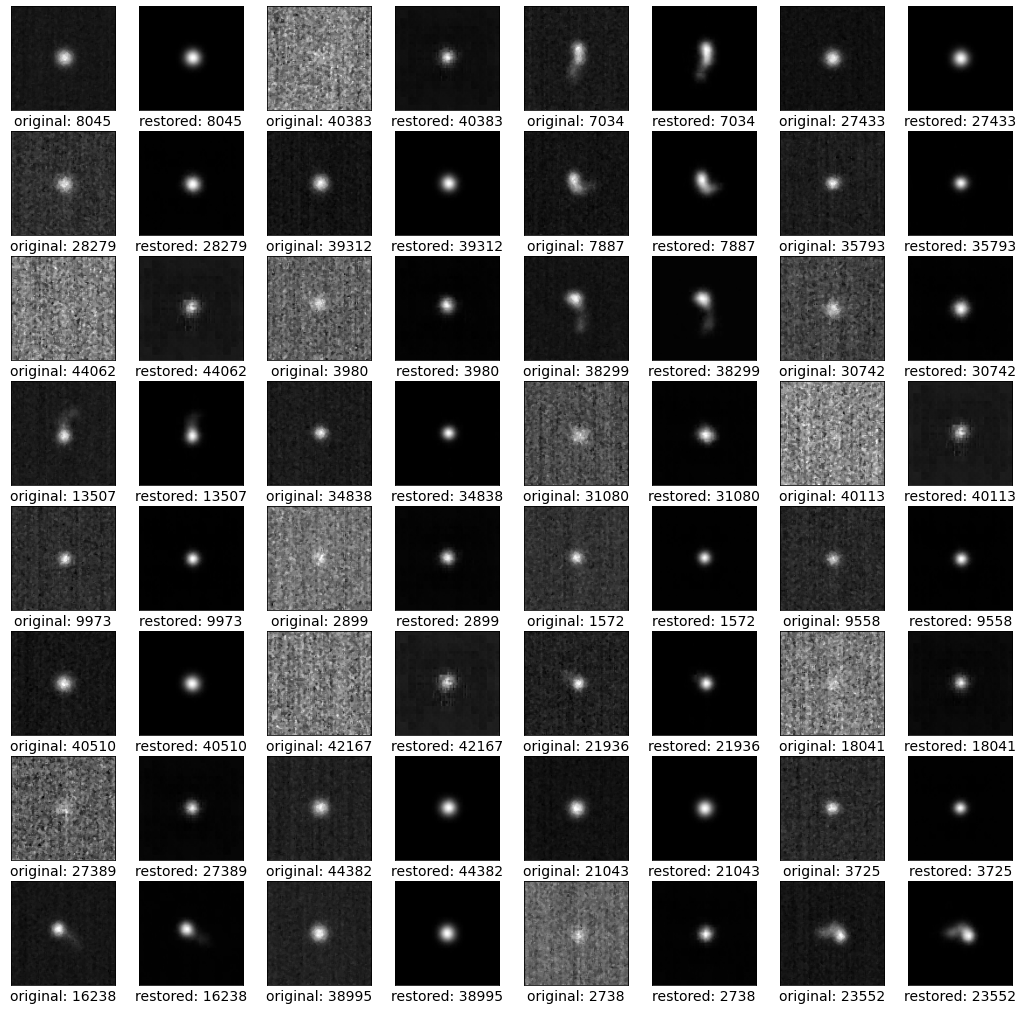

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(18, 18))

num_images = reduce(mul, axes.shape) // 2

random_state = np.random.RandomState(69)

images = valid.images
indices = random_state.choice(len(images), size=num_images, replace=False)

net.eval()

with torch.no_grad():
    images_original = images[indices]
    images = torch.tensor(images_original, dtype=torch.float, device=device).unsqueeze(1)
    *_, images_restored = net(images)
    images_restored = images_restored.cpu()[:, 0, :].detach()

for i, ax in enumerate(chain.from_iterable(axes)):
    if ax is None:
        break
    
    i, j = i // 2, i % 2
    if i < indices.shape[0]:
        img = (images_restored if j else images_original)[i]
        _ = ax.imshow(img, cmap='gray')
    else:
        img = None

    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_xticks([])

    if img is not None:
        k = indices[i]
        name = f'restored: {k}' if j else f'original: {k}'
        _ = ax.set_xlabel(name, fontsize=14)
    _ = ax.set(aspect='equal')

In [ ]:
class HookRegister:
    def __init__(self, module):
        self.output = None
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, grad_in, grad_out):
        self.output = grad_out

    def close(self):
        self.hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()


class CNNLayerVisualization:
    def __init__(self, model, selected_layer, selected_filter, seed=None):
        self.model = model
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.selected_output = None
        self.random_state = np.random.RandomState(seed)

    def visualise(self, optimizer, opt_steps=32):
        random_image = np.uint8(self.random_state.uniform(50, 160, (120, 120)))
        random_image = random_image[np.newaxis, np.newaxis, :]
        random_image = torch.tensor(random_image, dtype=torch.float, device=device)

        self.model.eval()

        with HookRegister(self.selected_layer) as hook:
            for i in range(opt_steps):
                optimizer.zero_grad()
                _ = self.model(random_image)
                
                loss = -hook.output[:, self.selected_filter].mean()
                loss.backward()
                optimizer.step()
            
            optimizer.zero_grad()
            self.selected_output = hook.output[0, self.selected_filter]

        return self.selected_output

In [ ]:
num_filters = 16
out_filters = []

for selected_filter in range(num_filters):
    visio = CNNLayerVisualization(
        model=net,
        selected_layer=list(net._encoder.children())[1],
        selected_filter=selected_filter,
        # seed=1932,
    )

    res = visio.visualise(optimizer, opt_steps=32)
    res = res.cpu().detach().numpy()

    out_filters.append(res)

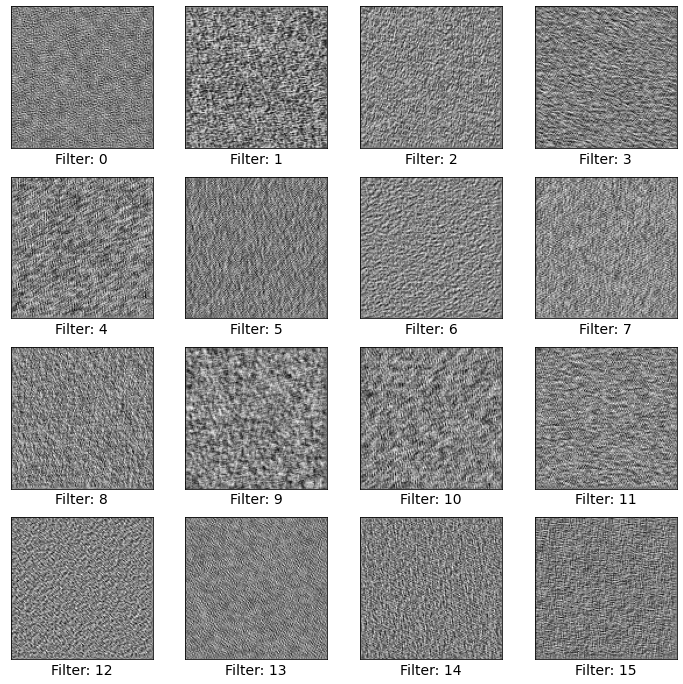

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, (ax, img) in enumerate(zip_longest(chain.from_iterable(axes), out_filters)):
    if ax is None:
        break
    
    if img is not None:
        _ = ax.imshow(img, cmap='gray')
    
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_xticks([])

    _ = ax.set_xlabel(f'Filter: {i}', fontsize=14)
    _ = ax.set(aspect='equal')

In [ ]:
num_filters = 32
out_filters = []

for selected_filter in range(num_filters):
    visio = CNNLayerVisualization(
        model=net,
        selected_layer=list(net._encoder.children())[5],
        selected_filter=selected_filter,
        # seed=1932,
    )

    res = visio.visualise(optimizer, opt_steps=32)
    res = res.cpu().detach().numpy()

    out_filters.append(res)

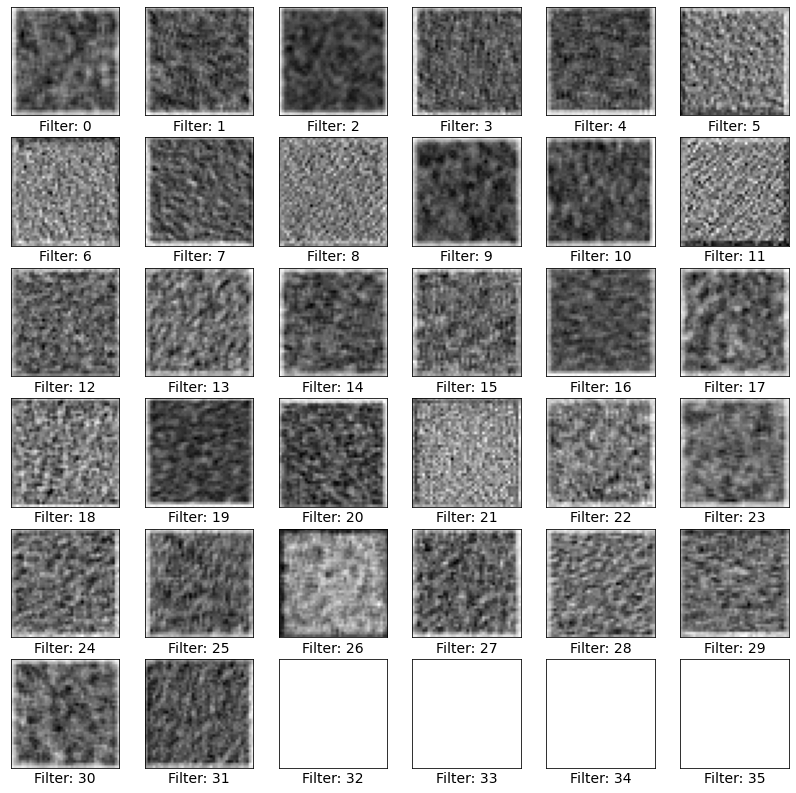

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(14, 14))

for i, (ax, img) in enumerate(zip_longest(chain.from_iterable(axes), out_filters)):
    if ax is None:
        break
    
    if img is not None:
        _ = ax.imshow(img, cmap='gray')
    
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_xticks([])

    _ = ax.set_xlabel(f'Filter: {i}', fontsize=14)
    _ = ax.set(aspect='equal')

In [19]:
try:
    model_best
except NameError as e:
    print(e)
    # I will use best pretrained model
    model_best = '/content/drive/My Drive/idao-2021/checkpoints_3.cool/model_iter_94.model'

model_best

'/content/drive/My Drive/idao-2021/checkpoints_3.cool/model_iter_94.model'

In [20]:
net.load_state_dict(torch.load(model_best))

<All keys matched successfully>

In [21]:
!pip install plotly
!pip install MulticoreTSNE

clear_output()

In [22]:
import plotly.graph_objects as go


def plot_points(fig, points, clusters, hovertext):
    for i in range(max(clusters) + 1):
        mask_cl = np.where(clusters == i)[0]

        fig.add_trace(go.Scattergl(
            x=points[mask_cl, 0],
            y=points[mask_cl, 1],
            hovertext=hovertext[mask_cl],
            mode='markers',
            marker=dict(
                line=dict(width=1, color='black'),
            ),
            showlegend=True,
            name='cluster_{}'.format(i),
        ))


def plot_centroids(fig, points, name='centroids'):
    fig.add_trace(go.Scattergl(
        x=points[:, 0],
        y=points[:, 1],
        mode='markers',
        marker=dict(
            line=dict(width=1, color='black'),
            symbol='x',
            size=14,
        ),
        showlegend=True,
        name=name,
    ))

In [23]:
dataset_train = IDAODataset.from_path(
    path='idao_dataset/train',
    transform=None,
    apply_transform_optional=False,
    has_target=True,
)

dataset_test_public = IDAODataset.from_path(
    path='idao_dataset/public_test',
    transform=None,
    apply_transform_optional=False,
    has_target=False,
)

dataset_test_private_old = IDAODataset.from_path(
    path='idao_dataset/private_test',
    transform=None,
    apply_transform_optional=False,
    has_target=False,
)

dataset_test_private_new = IDAODataset.from_path(
    path='idao_dataset/private_test_new',
    transform=None,
    apply_transform_optional=False,
    has_target=False,
)

dataset_test_private = IDAODataset(
    images=np.vstack([dataset_test_private_old.images, dataset_test_private_new.images]),
    labels=None,
    values=None,
    filenames=np.hstack([dataset_test_private_old.filenames, dataset_test_private_new.filenames]),
)

del dataset_test_private_old, dataset_test_private_new

100%|██████████| 15058/15058 [01:21<00:00, 184.02it/s]


In [24]:
from MulticoreTSNE import MulticoreTSNE as TSNE

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [25]:
mean_latent = []

for images, *_ in dataset_train:
    params, *_ = net(images)
    mean_latent_ = params[0].cpu().detach().numpy()
    mean_latent.append(mean_latent_)

for images, *_ in dataset_test_public:
    params, *_ = net(images)
    mean_latent_ = params[0].cpu().detach().numpy()
    mean_latent.append(mean_latent_)

for images, *_ in dataset_test_private:
    params, *_ = net(images)
    mean_latent_ = params[0].cpu().detach().numpy()
    mean_latent.append(mean_latent_)

mean_latent = np.vstack(mean_latent)
mean_latent.shape

(45026, 512)

In [26]:
latent_indices = np.where((mean_latent > 0).sum(axis=0) > 0)[0]
latent_indices

array([  0,  22,  29,  53, 108, 114, 117, 120, 122, 134, 150, 164, 195,
       201, 221, 229, 249, 268, 289, 291, 292, 298, 301, 309, 321, 338,
       357, 386, 389, 390, 409, 422, 423, 439, 452, 467, 470, 479, 483,
       504, 506])

In [27]:
mean_latent = mean_latent[:, latent_indices]
mean_latent.shape

(45026, 41)

In [28]:
%%time

tsne = TSNE(n_jobs=NUM_THREADS, method='exact', perplexity=120, learning_rate=150,
            n_iter=1000, random_state=9876, verbose=1)

mean_latent_tsne = tsne.fit_transform(mean_latent)
mean_latent_tsne.shape

CPU times: user 17min 6s, sys: 1.12 s, total: 17min 7s
Wall time: 9min 36s


In [29]:
_, dataset_train_tsne = dataset_train.split(test_size=0.074, random_state=67)
_, dataset_test_tsne = dataset_test_private.split(test_size=0.074, random_state=67)

In [30]:
mean_latent_train        = mean_latent[:len(dataset_train.indices)]
mean_latent_test_public  = mean_latent[len(dataset_train.indices):-len(dataset_test_private.indices)]
mean_latent_test_private = mean_latent[-len(dataset_test_private.indices):]

In [31]:
mean_latent_tsne_train        = mean_latent_tsne[:len(dataset_train.indices)]
mean_latent_tsne_test_public  = mean_latent_tsne[len(dataset_train.indices):-len(dataset_test_private.indices)]
mean_latent_tsne_test_private = mean_latent_tsne[-len(dataset_test_private.indices):]

In [32]:
kmeans_train = KMeans(n_clusters=6, random_state=54)
clusters_train = kmeans_train.fit_predict(mean_latent_tsne_train)

np.bincount(clusters_train)

array([2344, 2265, 2307, 2050, 2179, 2259])

In [33]:
kmeans_test = KMeans(n_clusters=6, random_state=54)
clusters_test = kmeans_test.fit_predict(mean_latent_tsne_test_private)

np.bincount(clusters_test)

array([5057, 3222, 4978, 4927, 5069, 6867])

In [34]:
fig = go.Figure()

points = np.vstack([
    mean_latent_tsne_train[dataset_train_tsne.indices],
    mean_latent_tsne_test_private[dataset_test_tsne.indices],
])

clusters = np.hstack([
    dataset_train_tsne.labels[dataset_train_tsne.indices],
    [dataset_train_tsne.labels.max() + 1] * len(dataset_test_tsne.indices)
])

hovertext = np.hstack([
    dataset_train_tsne.filenames[dataset_train_tsne.indices],
    dataset_test_tsne.filenames[dataset_test_tsne.indices]
])

plot_points(
    fig=fig,
    points=points,
    clusters=clusters,
    hovertext=hovertext,
)

plot_centroids(
    fig=fig,
    points=kmeans_train.cluster_centers_,
    name='centroids_train',
)

plot_centroids(
    fig=fig,
    points=kmeans_test.cluster_centers_,
    name='centroids_test_private',
)

fig.update_layout(
    autosize=False,
    width=900,
    height=800,
)

fig.show()

In [35]:
fig = go.Figure()

points = np.vstack([
    mean_latent_tsne_train[dataset_train_tsne.indices],
    mean_latent_tsne_test_private[dataset_test_tsne.indices],
])

clusters = np.hstack([
    dataset_train_tsne.values[dataset_train_tsne.indices],
    [dataset_train_tsne.values.max() + 1] * len(dataset_test_tsne.indices)
])

hovertext = np.hstack([
    dataset_train_tsne.filenames[dataset_train_tsne.indices],
    dataset_test_tsne.filenames[dataset_test_tsne.indices]
])

plot_points(
    fig=fig,
    points=points,
    clusters=clusters,
    hovertext=hovertext,
)

plot_centroids(
    fig=fig,
    points=kmeans_train.cluster_centers_,
    name='centroids_train',
)

plot_centroids(
    fig=fig,
    points=kmeans_test.cluster_centers_,
    name='centroids_test_private',
)

fig.update_layout(
    autosize=False,
    width=900,
    height=800,
)

fig.show()

In [36]:
fig = go.Figure()

points = np.vstack([
    mean_latent_tsne_train[dataset_train_tsne.indices],
    mean_latent_tsne_test_private[dataset_test_tsne.indices],
])

clusters = np.hstack([
    clusters_train[dataset_train_tsne.indices],
    clusters_test[dataset_test_tsne.indices] + clusters_train.max() + 1,
])

hovertext = np.hstack([
    dataset_train_tsne.filenames[dataset_train_tsne.indices],
    dataset_test_tsne.filenames[dataset_test_tsne.indices]
])

plot_points(
    fig=fig,
    points=points,
    clusters=clusters,
    hovertext=hovertext,
)

plot_centroids(
    fig=fig,
    points=kmeans_train.cluster_centers_,
    name='centroids_train',
)

plot_centroids(
    fig=fig,
    points=kmeans_test.cluster_centers_,
    name='centroids_test_private',
)

fig.update_layout(
    autosize=False,
    width=900,
    height=800,
)

fig.show()

In [37]:
import pandas as pd

In [38]:
clusters_map = {}

In [39]:
clusters_val = kmeans_train.predict(mean_latent_tsne_test_public)
clusters_map.update(zip(dataset_test_public.filenames, clusters_val))

In [40]:
clusters_val = kmeans_test.predict(mean_latent_tsne_test_private) + kmeans_train.n_clusters
clusters_map.update(zip(dataset_test_private.filenames, clusters_val))

In [41]:
clusters_map = {k.rsplit('.', 1)[0]: v for k, v in clusters_map.items()}

len(clusters_map)

31622

In [42]:
df_clusters = pd.DataFrame.from_dict(
    {k: [v] for k, v in clusters_map.items()},
    orient='index',
    columns=['cluster'],
)
df_clusters.index.rename('id', inplace=True)
df_clusters.head()

,cluster
id,
001ec8f4d2679f2899a63e4b2597c0a10bd9393f,5
00327390bfd6101b87106e96e0efc1c938690e1f,1
00573dde8addbac780cfa35a55a790fa1aa45178,5
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,1
00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,1


In [43]:
df_clusters.to_csv(os.path.join(WORK_DIR, 'clusters.csv'))

In [44]:
def make_count_classes_table(df, target):
    df = df.groupby('clusters')[target].value_counts().rename('count')
    df = pd.pivot(
        data=df.reset_index(),
        index='clusters',
        columns=target,
        values='count',
    ).fillna(0).astype(int)
    return df

In [45]:
clusters_known = pd.DataFrame()

clusters_known['clusters'] = kmeans_train.predict(mean_latent_tsne_train)
clusters_known['labels'] = dataset_train.labels
clusters_known['values'] = MAPPING_VALUE_INV[dataset_train.values]

In [46]:
clusters_known_labels = make_count_classes_table(clusters_known, 'labels')
clusters_known_labels

labels,0,1
clusters,,
0,2,2342
1,2255,10
2,1,2306
3,0,2050
4,2177,2
5,2211,48


In [47]:
clusters_known_labels = clusters_known_labels.idxmax(axis=1).to_dict()
clusters_known_labels

{0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0}

In [48]:
clusters_known_values = make_count_classes_table(clusters_known, 'values')
clusters_known_values

values,1,3,6,10,20,30
clusters,,,,,,
0,1,2195,1,0,2,145
1,3,11,2250,1,0,0
2,0,2,0,2232,0,73
3,0,37,1,39,0,1973
4,2176,0,3,0,0,0
5,0,0,1,2,2208,48


In [49]:
clusters_known_values = clusters_known_values.idxmax(axis=1).to_dict()
clusters_known_values

{0: 3, 1: 6, 2: 10, 3: 30, 4: 1, 5: 20}

In [50]:
# one of my best submissions (id = 49820224)

submission_clf = pd.concat([
    pd.read_csv(os.path.join(WORK_DIR, 'submission_004-2_old.csv'), index_col='id'),
    pd.read_csv(os.path.join(WORK_DIR, 'submission_004-2_new.csv'), index_col='id'),
], axis=0)
submission_clf = submission_clf[~submission_clf.index.duplicated(keep='first')]
submission_clf = pd.merge(submission_clf, df_clusters, left_index=True, right_index=True)
submission_clf.head()

,classification_predictions,regression_predictions,cluster
id,,,
001ec8f4d2679f2899a63e4b2597c0a10bd9393f,0.000231,20,5
00327390bfd6101b87106e96e0efc1c938690e1f,0.000472,6,1
00573dde8addbac780cfa35a55a790fa1aa45178,0.000218,20,5
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,0.000594,6,1
00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,0.001235,6,1


In [51]:
def make_count_classes_table(df, target):
    df = df.groupby('cluster')[target].value_counts().rename('count')
    df = pd.pivot(
        data=df.reset_index(),
        index='cluster',
        columns=target,
        values='count',
    ).fillna(0).astype(int)
    return df

In [52]:
make_count_classes_table(submission_clf, 'regression_predictions')[MAPPING_VALUE].loc[6:]

regression_predictions,1,3,6,10,20,30
cluster,,,,,,
6,0,14,0,299,1755,2981
7,3160,41,19,0,2,0
8,0,0,4601,370,6,0
9,0,2454,3,2464,0,6
10,0,0,0,5,1505,3559
11,4048,1031,1699,0,0,9


Labeling is done according to data distribution in train and test

|Energy| He   | e |
| ---  | ---- |---|
| 1    |  *   | - |
| 3    |  -   | * |
| 6    |  *   | - |
| 10   |  -   | * |
| 20   |  *   | - |
| 30   |  -   | * |

\* – train; - – test.

Also these factor are take into account for labeling:
* mutual positions of clusters (images above);
* basic classifier's predictions (`submission_clf`).




In [54]:
submission_clf.groupby('cluster')['classification_predictions'].mean().iloc[6:]

cluster
6     0.768443
7     0.087866
8     0.003449
9     0.999941
10    0.484550
11    0.189551
Name: classification_predictions, dtype: float64

In [55]:
# tsne is not stable, clusters' order is not stable
# so relabeling will be needed after rerun

clusters_unknown_labels = {
     6: 1, 
     7: 1,  # not confident here
     8: 0,
     9: 1,
    10: 0,
    11: 0,  # not confident here
}

In [56]:
def styler(s):
    color = 'lightpink' if clusters_unknown_labels[s.name] == 1 else 'lightblue'
    return [f'background-color: {color}'] * len(s)

df_tmp = make_count_classes_table(submission_clf, 'regression_predictions')[MAPPING_VALUE].loc[6:]
df_tmp.style.apply(styler, axis=1)

regression_predictions,1,3,6,10,20,30
cluster,,,,,,
6,0,14,0,299,1755,2981
7,3160,41,19,0,2,0
8,0,0,4601,370,6,0
9,0,2454,3,2464,0,6
10,0,0,0,5,1505,3559
11,4048,1031,1699,0,0,9


In [57]:
clusters_unknown_values = {
     6: 20,
     7: 1,   # not confident here
     8: 10,
     9: 6,
    10: 30,
    11: 3,   # not confident here
}

In [58]:
clusters_labels = {}
clusters_labels.update(clusters_known_labels)
clusters_labels.update(clusters_unknown_labels)

In [59]:
clusters_values = {}
clusters_values.update(clusters_known_values)
clusters_values.update(clusters_unknown_values)

In [65]:
from sklearn.neighbors import NearestNeighbors

In [66]:
clusters = kmeans_test.predict(mean_latent_tsne_test_private)

# According to statement https://www.youtube.com/watch?v=VzH_58yYz5k
# there are ~2400 examples per class (we use test_old and test_new)

nn = NearestNeighbors(n_neighbors=4000)
points = set()

for c in range(kmeans_test.n_clusters):
    if c + kmeans_train.n_clusters in {7, 11}:
        continue
    
    mask = clusters == c

    nn.fit(mean_latent_tsne_test_private[mask])

    indices = nn.kneighbors(kmeans_test.cluster_centers_[[c]], return_distance=False)
    points_ = dataset_test_private.filenames[mask][indices]
    points_ = {k.rsplit('.', 1)[0] for k in points_.ravel()}
    points.update(points_)

len(points)

16000

In [67]:
for c, group in submission_clf.groupby('cluster'):
    if not c in {7, 11}:
        continue

    if clusters_unknown_labels[c]:
        points_ = set(group.nlargest(800, 'classification_predictions').index)
        points.update(points_)
    else:
        points_ = set(group.nsmallest(800, 'classification_predictions').index)
        points.update(points_)

len(points)

17600

In [68]:
examples_extra = df_clusters[df_clusters.index.isin(points)]
examples_extra['label'] = examples_extra['cluster'].map(clusters_labels)
examples_extra['value'] = examples_extra['cluster'].map(clusters_values)
examples_extra.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,label,value
id,,,
0002894871bb30af2670648c58b2506e9801a321,6,1,20
000a95ca23df016a149ff9af94b6e9d8633d6691,10,0,30
000c45d729066044e3dd3f885fddf013b845b6d7,6,1,20
0011f80e44faa713714ead6aeab3b2f9db54aebd,8,0,10
0019c489db95ca9ee6e558274700ef3d76d37532,10,0,30


In [69]:
examples_extra.to_csv(os.path.join(WORK_DIR, 'examples_extra.csv'))